In [98]:
import re
import os
import string
import nltk
import spacy
import unicodedata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from contractions import contractions_dict

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from xgboost import XGBClassifier


In [2]:
%matplotlib inline
stop_words = set(stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')

In [3]:
business_directory = os.listdir('bbc/business/')
entertainment_directory = os.listdir('bbc/entertainment/')
politics_directory = os.listdir('bbc/politics/')
sport_directory = os.listdir('bbc/sport/')
tech_directory = os.listdir('bbc/tech/')

In [4]:
# df = pd.DataFrame()

In [5]:
# for file in tech_directory:
#     with open('bbc/tech/' + file, encoding="utf8", errors='ignore') as f:
#         t = f.read()
#         t = str(t)
#         df = df.append({'text': t, 'category': 'tech'}, ignore_index=True)
#         f.close()


In [6]:
# df.to_csv('bbc_news.csv', index=False)

In [7]:
df = pd.read_csv('bbc_news.csv')

In [8]:
df.head()

,category,text
0,business,UK economy facing 'major risks'\n\nThe UK manu...
1,business,Aids and climate top Davos agenda\n\nClimate c...
2,business,Asian quake hits European shares\n\nShares in ...
3,business,India power shares jump on debut\n\nShares in ...
4,business,Lacroix label bought by US firm\n\nLuxury good...


In [9]:
df['text'].iloc[0]

'UK economy facing \'major risks\'\n\nThe UK manufacturing sector will continue to face "serious challenges" over the next two years, the British Chamber of Commerce (BCC) has said.\n\nThe group\'s quarterly survey of companies found exports had picked up in the last three months of 2004 to their best levels in eight years. The rise came despite exchange rates being cited as a major concern. However, the BCC found the whole UK economy still faced "major risks" and warned that growth is set to slow. It recently forecast economic growth will slow from more than 3% in 2004 to a little below 2.5% in both 2005 and 2006.\n\nManufacturers\' domestic sales growth fell back slightly in the quarter, the survey of 5,196 firms found. Employment in manufacturing also fell and job expectations were at their lowest level for a year.\n\n"Despite some positive news for the export sector, there are worrying signs for manufacturing," the BCC said. "These results reinforce our concern over the sector\'s p

## Text Processing Functions

In [10]:
def clean_text(text):
    string = str(text)
    tokens = word_tokenize(string)
    words = [word.lower() for word in tokens if word.isalpha()]
    return words
    
def remove_stop_words(words):
    words = [w for w in words if not w in stop_words]
    return words

In [11]:
def lemmatize_text(words):
    lemm = WordNetLemmatizer()
    new_words = []
    for word in words:
        new_word = lemm.lemmatize(word)
        new_words.append(new_word)
        
    return words

In [12]:
def expand_contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [13]:
def text_process(text):
    cleaned_words = clean_text(text)
    for word in cleaned_words:
        word = expand_contractions(word)
    filtered_words = remove_stop_words(cleaned_words)
    lemmatized_words = lemmatize_text(filtered_words)
    return lemmatized_words

# Bag of Words

In [14]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['text'])

In [15]:
text_bow = bow_transformer.transform(df['text'])

# TF-IDF

In [16]:
tfidf_transformer = TfidfTransformer().fit(text_bow)

In [17]:
text_tfidf = tfidf_transformer.transform(text_bow)

# Model Building

In [18]:
X = text_tfidf
y = df['category']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

### K-Fold Validation

In [20]:
kfold = StratifiedKFold(n_splits=10)

### Model Selection

In [24]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(LinearSVC(random_state=random_state))
classifiers.append(NuSVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(XGBClassifier())
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MultinomialNB())
classifiers.append(BernoulliNB())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SGDClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier,
                                      X = X,
                                      y = y,
                                      scoring = "accuracy",
                                      cv = kfold,
                                      n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will r

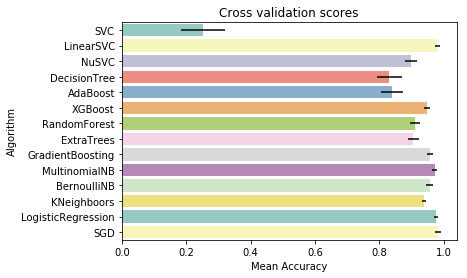

In [104]:
cv_res = pd.DataFrame({"CrossValMeans": cv_means,
                               "CrossValerrors": cv_std,
                               "Instances": [classifier for classifier in classifiers],
                               "Algorithm": ["SVC",
                                             "LinearSVC",
                                             "NuSVC",
                                             "DecisionTree",
                                             "AdaBoost",
                                             "XGBoost",
                                             "RandomForest",
                                             "ExtraTrees",
                                             "GradientBoosting",
                                             "MultinomialNB",
                                             "BernoulliNB",
                                             "KNeighboors",
                                             "LogisticRegression",
                                             "SGD"
                                             ]
                               })

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [105]:
cv_res

,CrossValMeans,CrossValerrors,Instances,Algorithm
0,0.252331,0.068488,"SVC(C=1.0, cache_size=200, class_weight=None, ...",SVC
1,0.980659,0.008319,"LinearSVC(C=1.0, class_weight=None, dual=True,...",LinearSVC
2,0.898044,0.018475,"NuSVC(cache_size=200, class_weight=None, coef0...",NuSVC
3,0.831482,0.039582,"DecisionTreeClassifier(class_weight=None, crit...",DecisionTree
4,0.839127,0.034723,"AdaBoostClassifier(algorithm='SAMME.R',\n ...",AdaBoost
5,0.949209,0.009874,"XGBClassifier(base_score=0.5, booster='gbtree'...",XGBoost
6,0.911881,0.014928,"RandomForestClassifier(bootstrap=True, class_w...",RandomForest
7,0.905173,0.017050,"ExtraTreesClassifier(bootstrap=False, class_we...",ExtraTrees
8,0.958186,0.010129,GradientBoostingClassifier(criterion='friedman...,GradientBoosting
9,0.972116,0.007244,"MultinomialNB(alpha=1.0, class_prior=None, fit...",MultinomialNB


In [121]:
cv_res.sort_values('CrossValMeans', ascending=False, inplace=True)

### Chosen Models:
- SGD
- LinearSVC
- LogisticRegression
- MultinomialNB
- GradientBossting
- BernoulliNB
- XGBoost

# Tuning and Model Building

## SGD

In [54]:
sgdc = SGDClassifier(random_state=random_state)
sgdc_params = {
    'loss':['log', 'hinge'],
    'penalty':['l1', 'l2', 'elasticnet'],
    'max_iter':[5],
    'alpha':np.logspace(-4, 4, 10),
    'l1_ratio':[0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.13,0.14,0.15,0.2]
}
sgdc_gs = GridSearchCV(sgdc, sgdc_params, cv=kfold, verbose=1, n_jobs=-1)
sgdc_gs.fit(X_train, y_train)
sgdc_best = sgdc_gs.best_estimator_
sgdc_gs.best_score_  

Fitting 10 folds for each of 660 candidates, totalling 6600 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6352 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6600 out of 6600 | elapsed:  1.7min finished


0.9865168539325843

## LinearSVC

In [55]:
linSVC = LinearSVC(random_state=random_state)
linSVC_params = {
    'penalty':['l2'],
    'loss':['squared_hinge', 'hinge'],
    'max_iter':[5],
    'C': [1, 10, 100, 1000],
}
linSVC_gs = GridSearchCV(linSVC, linSVC_params, cv=kfold, verbose=1, n_jobs=4)
linSVC_gs.fit(X_train, y_train)
linSVC_best = linSVC_gs.best_estimator_
linSVC_gs.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.8s finished


0.9865168539325843

## LogisticRegression

In [67]:
logR = LogisticRegression(random_state=random_state)
logR_params = {
    'penalty':['l1', 'l2'],
    'max_iter':[5],
    'C': [1, 10, 100, 1000]
}
logR_gs = GridSearchCV(logR, logR_params, cv=kfold, verbose=1, n_jobs=4)
logR_gs.fit(X_train, y_train)
logR_best = logR_gs.best_estimator_
logR_gs.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    4.0s finished


0.9827715355805243

## MultinomialNB

In [69]:
mNB = MultinomialNB()
mNB_params = {
    'alpha':np.logspace(-4, 4, 10),
    'fit_prior': [True, False]
}
mNB_gs = GridSearchCV(mNB, mNB_params, cv=kfold, verbose=1, n_jobs=4)
mNB_gs.fit(X_train, y_train)
mNB_best = mNB_gs.best_estimator_
mNB_gs.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


0.9745318352059925

## GradientBoosting

In [83]:
# gboost = GradientBoostingClassifier()
# gboost_params = {
#     'learning_rate':[0.1, 0.05, 0.001],
#     'n_estimators':[100, 500, 1000, 1500],
#     'max_depth':[2,3,4,5,6,7]
# #     'min_samples_split':[2,4,6,8,10,20,40,60,100],
# #     'min_samples_leaf':[1,3,5,7,9],
# #     'max_features':[2,3,4,5,6,7],
# #     'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
# }
# gboost_gs = GridSearchCV(gboost, gboost_params, cv=kfold, verbose=1, n_jobs=4)
# gboost_gs.fit(X_train, y_train)
# gboost_best = gboost_gs.best_estimator_
# gboost_gs.best_score_

## BernoulliNB

In [85]:
bNB = BernoulliNB()
bNB_params = {
    'alpha':np.logspace(-4, 4, 10),
    'fit_prior': [True, False]
}
bNB_gs = GridSearchCV(bNB, bNB_params, cv=kfold, verbose=1, n_jobs=4)
bNB_gs.fit(X_train, y_train)
bNB_best = bNB_gs.best_estimator_
bNB_gs.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished


0.9745318352059925

## XGBoost

In [87]:
# xgb = XGBClassifier()
# xgb_params = {
# }
# xgb_gs = GridSearchCV(xgb, xgb_params, cv=kfold, verbose=1, n_jobs=4)
# xgb_gs.fit(X_train, y_train)
# xgb_best = xgb_gs.best_estimator_
# xgb_gs.best_score_

# Ensemble

In [93]:
voting_ensemble = VotingClassifier(estimators= [('SGD', sgdc_best),
                                                ('LogisticRegression', logR_best),
                                                ('MultinomialNB', mNB_best),
                                                ('LinearSVC', linSVC_best),
                                                ('BernoulliNB', bNB_best)
                                               ],
                                   voting='hard',
                                   n_jobs= 4
                                  )
voting_ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=2,
       shuffle...NB', BernoulliNB(alpha=0.005994842503189409, binarize=0.0, class_prior=None,
      fit_prior=True))],
         flatten_transform=None, n_jobs=4, voting='hard', weights=None)

In [100]:
final_predictions = voting_ensemble.predict(X_test)

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [99]:
print(classification_report(y_test, final_predictions))

               precision    recall  f1-score   support

     business       0.98      0.97      0.98       214
entertainment       0.98      0.99      0.98       147
     politics       0.98      0.96      0.97       180
        sport       0.98      0.99      0.99       193
         tech       0.97      0.99      0.98       156

  avg / total       0.98      0.98      0.98       890



In [101]:
accuracies = cross_val_score(estimator = voting_ensemble, X = X, y = y, cv=10)
accuracies.mean()

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will r

0.9829048291844387